In [ ]:
!pip install neuralcompression

In [ ]:
import matplotlib.pyplot
import numpy
import torch

from neuralcompression.data import Kodak
from neuralcompression.models import FactorizedPriorAutoencoder
import skimage.data
import skimage.transform
import torchvision.transforms
from PIL import Image
import urllib.request

Using /root/.cache/torch_extensions/py37_cu111 as PyTorch extensions root...
Emitting ninja build file /root/.cache/torch_extensions/py37_cu111/_pmf_to_quantized_cdf/build.ninja...
Building extension module _pmf_to_quantized_cdf...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module _pmf_to_quantized_cdf...


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


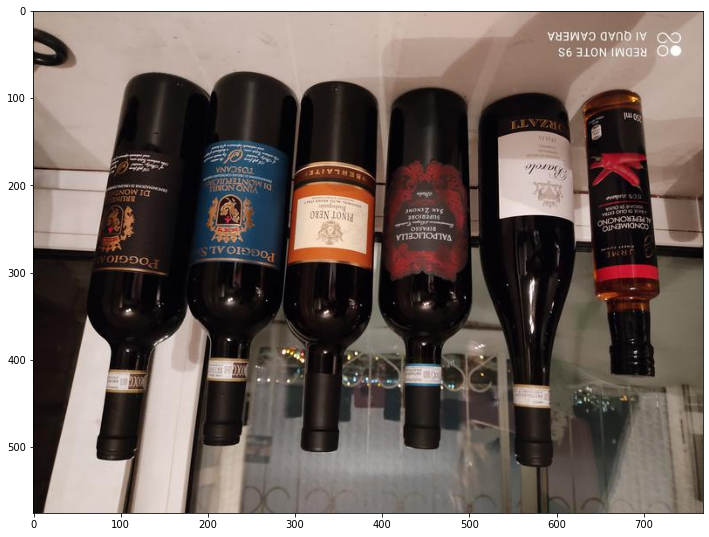

In [ ]:
file_name = "/content/drive/MyDrive/Deelvin_docs/image_compression/data_576_768/"
x = Image.open(file_name + '1.jpg')

transform = torchvision.transforms.Compose([
    torchvision.transforms.PILToTensor(),
    torchvision.transforms.ConvertImageDtype(torch.float32),
])

x = transform(x).unsqueeze(0)

matplotlib.pyplot.figure(figsize=(12, 18))

matplotlib.pyplot.imshow(x.squeeze().permute(1, 2, 0))

In [ ]:
network = FactorizedPriorAutoencoder()

url = "https://dl.fbaipublicfiles.com/neuralcompression/models/factorized_prior_vimeo_90k_mse_128_192_0_025.pth"

state_dict = torch.hub.load_state_dict_from_url(url)

network.load_state_dict(state_dict, strict=False)

In [ ]:
with torch.no_grad():
    strings, broadcast_size = network.compress(x)

sys.getsizeof() on the other hand returns the memory size of the object, this means you are not only getting the size of the bytes, as it a full object it also has its methods, attributes, addresses... which are all considered in that size.

In [ ]:
print(sys.getsizeof(x))
print(sys.getsizeof(strings))

88
80


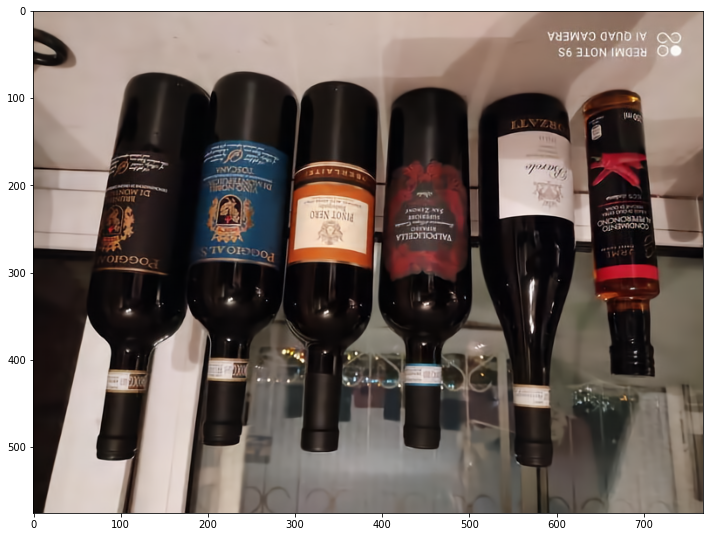

In [ ]:
with torch.no_grad():
    x_hat = network.decompress(strings, broadcast_size)

matplotlib.pyplot.figure(figsize=(12, 18))

matplotlib.pyplot.imshow(x_hat.squeeze().permute(1, 2, 0))

matplotlib.pyplot.show()

In [ ]:
from PIL import Image
import numpy as np

for i in range(1, 11):
  file_name = "/content/drive/MyDrive/Deelvin_docs/image_compression/data_576_768/"
  img = Image.open(file_name + str(i) + '.jpg')
  img.save("/content/drive/MyDrive/Deelvin_docs/image_compression/data_576_768_bmp/" + str(i) + '.bmp')

In [ ]:
for i in range(1, 11):
  file_name = "/content/drive/MyDrive/Deelvin_docs/image_compression/data_576_768_bmp/"
  x = Image.open(file_name + str(i) + '.jpg')

  transform = torchvision.transforms.Compose([
      torchvision.transforms.PILToTensor(),
      torchvision.transforms.ConvertImageDtype(torch.float32),
  ])

  x = transform(x).unsqueeze(0)
  with torch.no_grad():
      strings, broadcast_size = network.compress(x)
  with torch.no_grad():
      x_hat = network.decompress(strings, broadcast_size)

  print(i, ': ', psnr(x, x_hat))

1 :  34.10222326027991
2 :  35.77473638682254
3 :  34.50707778654543
4 :  34.656545657818334
5 :  34.59083169207446
6 :  34.74309066187762
7 :  34.60931224779277
8 :  34.69910765608364
9 :  36.9609377446131
10 :  34.95260105799962


## Evaluation

### PSNR

In [ ]:
import math

from torch import Tensor

import torch.nn.functional as F



def psnr(x: Tensor, x_hat: Tensor) -> float:
    return -10 * math.log10(F.mse_loss(x, x_hat).item())

psnr(x, x_hat)

34.94101424460837

In [ ]:
# coding=utf-8
import cv2
import numpy as np


def calcEntropy(img):
    entropy = []

    hist = cv2.calcHist([img], [0], None, [256], [0, 255])
    total_pixel = img.shape[0] * img.shape[1]

    for item in hist:
        probability = item / total_pixel
        if probability == 0:
            en = 0
        else:
            en = -1 * probability * (np.log(probability) / np.log(2))
        entropy.append(en)

    sum_en = np.sum(entropy)
    return sum_en


if __name__ == '__main__':
    img1 = cv2.imread("/content/drive/MyDrive/Deelvin_docs/image_compression/data_576_768_bmp/1.bmp", cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread("/content/drive/MyDrive/Deelvin_docs/image_compression/data_576_768_bmp/2.bmp", cv2.IMREAD_GRAYSCALE)

    entropy1 = calcEntropy(img1)
    entropy2 = calcEntropy(img2)

    print(entropy1)

[7.54402611]


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [ ]:
for i in range(1, 11):
  file_stats = os.stat("/content/drive/MyDrive/Deelvin_docs/image_compression/data_576_768_bmp/" + str(i) + ".bmp")
  print(f'File Size in Bytes is {file_stats.st_size}')
  print('file:', str(i))
  print((file_stats.st_size * 8) / (576*768))

File Size in Bytes is 1327158
file: 1
24.0009765625
File Size in Bytes is 1327158
file: 2
24.0009765625
File Size in Bytes is 1327158
file: 3
24.0009765625
File Size in Bytes is 1327158
file: 4
24.0009765625
File Size in Bytes is 1327158
file: 5
24.0009765625
File Size in Bytes is 1327158
file: 6
24.0009765625
File Size in Bytes is 1327158
file: 7
24.0009765625
File Size in Bytes is 1327158
file: 8
24.0009765625
File Size in Bytes is 1327158
file: 9
24.0009765625
File Size in Bytes is 1327158
file: 10
24.0009765625


General answer:

Bits per pixel = Bits/Pixel, 1 Byte = 8 Bits

In [ ]:
print((1327158 * 8) / (576*768))

24.0009765625
